In [ ]:
!pip install kaggle -q

from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tthien/shanghaitech
!unzip -q shanghaitech.zip -d CrowdDataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tthien/shanghaitech
License(s): unknown
 98% 327M/333M [00:00<00:00, 692MB/s]
100% 333M/333M [00:00<00:00, 711MB/s]


In [ ]:
import os
import cv2
import numpy as np
import scipy.io as sio
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [ ]:
def generate_density_map(img_path, gt_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    mat = sio.loadmat(gt_path)
    points = mat["image_info"][0,0][0,0][0]  # head annotations

    density_map = np.zeros((h, w), dtype=np.float32)

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))
        density_map[y, x] = 1

    density_map = gaussian_filter(density_map, sigma=15)
    return density_map


In [ ]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.img_list = sorted(os.listdir(img_dir))
        self.gt_list = sorted(os.listdir(gt_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_list[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        density_map = generate_density_map(img_path, gt_path)
        density_map = cv2.resize(density_map, (256, 256))

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

        density_map = torch.from_numpy(density_map).unsqueeze(0).float()

        return img, density_map


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
img_dir = "/content/CrowdDataset/ShanghaiTech/part_A/train_data/images"
gt_dir = "/content/CrowdDataset/ShanghaiTech/part_A/train_data/ground-truth"

transform = T.Compose([T.ToTensor()])
dataset = CrowdDataset(img_dir, gt_dir, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()


In [ ]:
epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, gts in loader:
        imgs, gts = imgs.to(device), gts.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, gts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")

def evaluate(model, loader):
    model.eval()
    mae, mse = 0, 0
    with torch.no_grad():
        for imgs, gts in loader:
            imgs, gts = imgs.to(device), gts.to(device)
            preds = model(imgs)
            mae += torch.abs(preds.sum() - gts.sum()).item()
            mse += ((preds.sum() - gts.sum())**2).item()
    mae /= len(loader)
    rmse = (mse / len(loader))**0.5
    return mae, rmse

mae, rmse = evaluate(model, loader)
print(f"Train MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Epoch 1/2 - Loss: 0.0005
Epoch 2/2 - Loss: 0.0001
Train MAE: 129.7957, RMSE: 176.3756


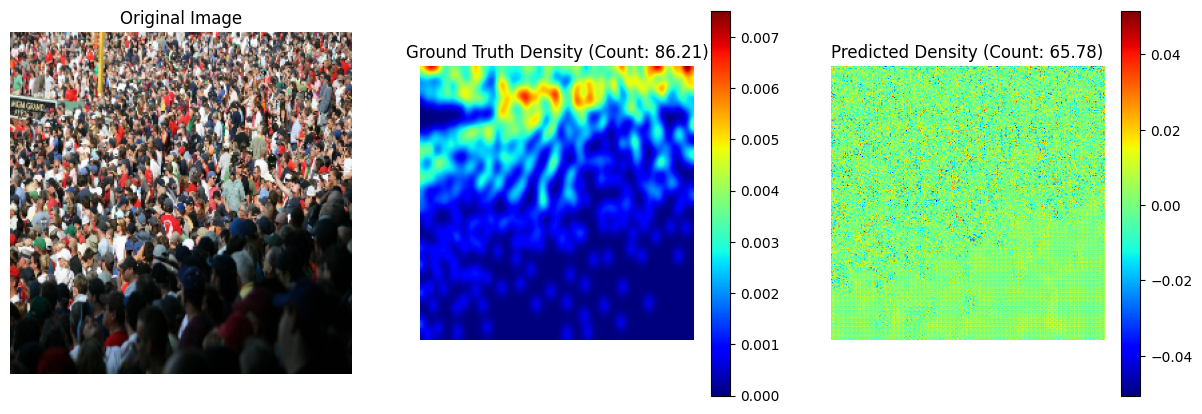

In [ ]:
import matplotlib.pyplot as plt

test_img, test_gt = dataset[1]
test_img = test_img.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predicted_density_map = model(test_img)

test_img = test_img.squeeze(0).cpu().permute(1, 2, 0).numpy()
predicted_density_map = predicted_density_map.squeeze().cpu().numpy()
test_gt = test_gt.squeeze().cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(test_gt, cmap='jet')
plt.title(f"Ground Truth Density (Count: {test_gt.sum():.2f})")
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_density_map, cmap='jet')
plt.title(f"Predicted Density (Count: {predicted_density_map.sum():.2f})")
plt.colorbar()
plt.axis('off')

plt.show()

In [ ]:
import torch.nn as nn
import torch

class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 16, 9, padding=4), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding=3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 7, padding=3), nn.ReLU(),
            nn.Conv2d(16, 8, 7, padding=3), nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(3, 20, 7, padding=3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(40, 20, 5, padding=2), nn.ReLU(),
            nn.Conv2d(20, 10, 5, padding=2), nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 24, 3, padding=1), nn.ReLU(),
            nn.Conv2d(24, 12, 3, padding=1), nn.ReLU()
        )

        self.fusion = nn.Sequential(
            nn.Conv2d(8+10+12, 1, 1, padding=0)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)

        x_cat = torch.cat((x1, x2, x3), 1)
        output = self.fusion(x_cat)
        return output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = MCNN().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

epochs = 2
for epoch in range(epochs):
    model1.train()
    total_loss = 0
    for imgs, gts in loader:
        imgs, gts = imgs.to(device), gts.to(device)
        preds = model1(imgs)
        gts = torch.nn.functional.interpolate(gts, size=preds.shape[-2:], mode='bilinear', align_corners=False)
        loss = loss_fn(preds, gts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")

Epoch 1/2 - Loss: 0.0001
Epoch 2/2 - Loss: 0.0000


In [ ]:
def evaluate(model, loader):
    model.eval()
    mae, mse = 0, 0
    with torch.no_grad():
        for imgs, gts in loader:
            imgs, gts = imgs.to(device), gts.to(device)
            preds = model(imgs)
            mae += torch.abs(preds.sum() - gts.sum()).item()
            mse += ((preds.sum() - gts.sum())**2).item()
    mae /= len(loader)
    rmse = (mse / len(loader))**0.5
    return mae, rmse

mae, rmse = evaluate(model, loader)
print(f"MCNN MAE: {mae:.4f}, RMSE: {rmse:.4f}")


MCNN MAE: 144.4117, RMSE: 215.1140


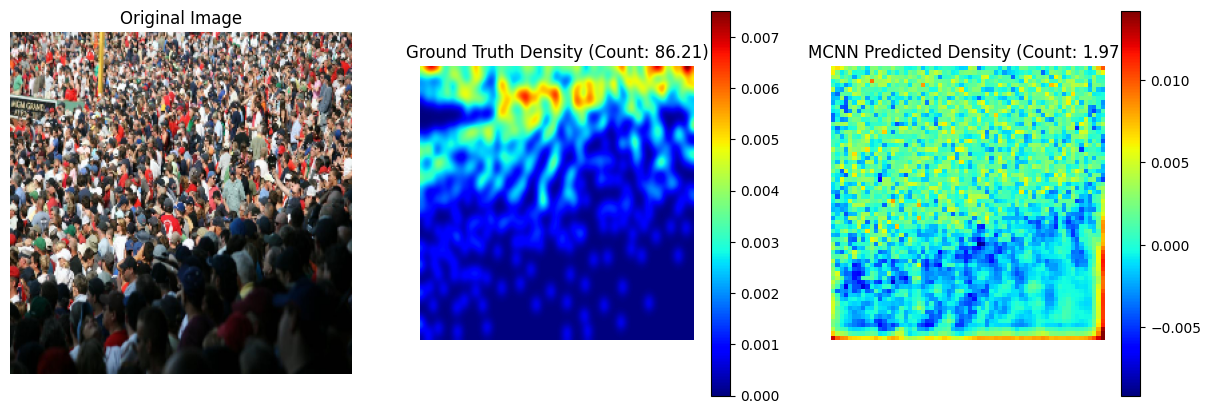

In [ ]:
test_img, test_gt = dataset[1]
test_img = test_img.unsqueeze(0).to(device)

model1.eval()
with torch.no_grad():
    predicted_density_map = model1(test_img)

test_img = test_img.squeeze(0).cpu().permute(1, 2, 0).numpy()
predicted_density_map = predicted_density_map.squeeze().cpu().numpy()
test_gt = test_gt.squeeze().cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(test_gt, cmap='jet')
plt.title(f"Ground Truth Density (Count: {test_gt.sum():.2f})")
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_density_map, cmap='jet')
plt.title(f"MCNN Predicted Density (Count: {predicted_density_map.sum():.2f})")
plt.colorbar()
plt.axis('off')

plt.show()